In [34]:
from Frequency_logchirp_pyinterface import Frequency_logchirp
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import signal
import torch.nn.functional as F
# from Frequency_dynamic_system_pyinterface import Frequency_dynamic_system

plt.rcParams['mathtext.fontset'] = 'stix'
mpl.rc('font', family='times new roman')
mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['font.size'] = 10

In [35]:
model = Frequency_logchirp(compile=False)
# fmin=np.array([0.1])
# fmax=np.array([1.0])
model.reset()

time_array = [model.current_time]
delta_omega = [model.deltaomega[0]]
delta_dotomega=[model.deltaomegadot[0]]
inputpower=[model.inputpower1[0]]

while model.current_time <= 310:
    model.one_step()
    time_array.append(model.current_time)
    delta_omega.append(model.deltaomega[0])
    delta_dotomega.append(model.deltaomegadot[0])
    inputpower.append(model.inputpower1[0])

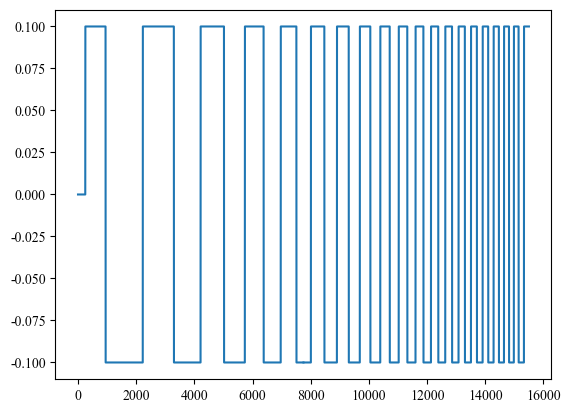

In [36]:
plt.plot(inputpower)

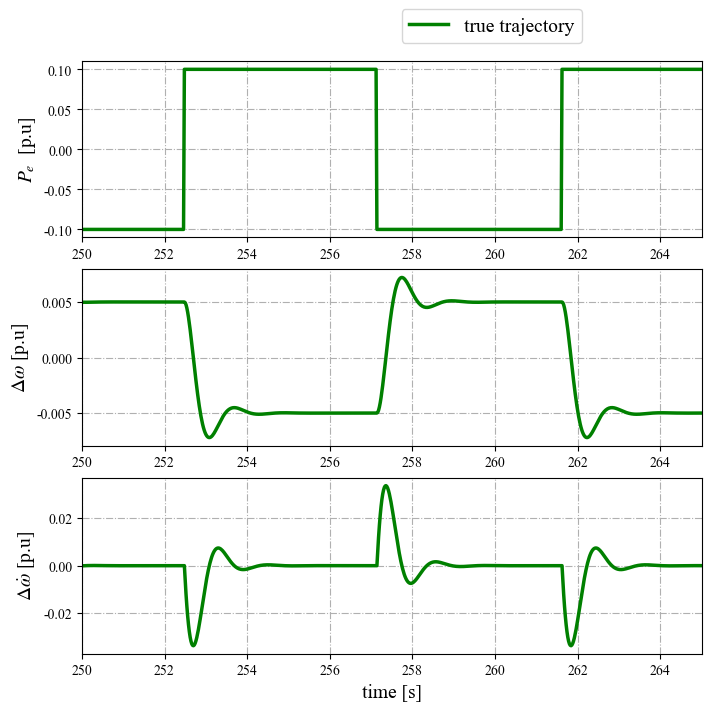

In [37]:
b=torch.tensor([[delta_omega[250:],delta_dotomega[250:]]],dtype=torch.float32)
# b=torch.tensor([[delta_omega[250:2501]]],dtype=torch.float32).to(device)
true_y0=torch.movedim(b,(0,2),(1,0))
t=torch.tensor(time_array[250:],dtype=torch.float32)
u=torch.tensor(inputpower[250:],dtype=torch.float32)

true_y0 = true_y0.transpose(0, 1)
y0 = true_y0[:, 0, :]
t = t.reshape((1, -1))
u0 = u.reshape((1, -1, 1))

def visualize(t,u, true_y, pred_y):
    fig0, ax = plt.subplots(3, 1, figsize=(7, 7), constrained_layout=True)
    ax[0].plot(t.numpy(), u.numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
    # ax[0].set_title('Trained Model')
    # ax[0].set_xlabel('time [s]', fontsize = 14)
    ax[0].set_ylabel(r'$P_e$  [p.u]', fontsize = 14)
    ax[1].plot(t.numpy(), true_y.numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
    # ax[0].set_title('Trained Model',fontsize=14)
    # ax[1].set_xlabel('time [s]', fontsize = 14)
    ax[1].set_ylabel(r'$\Delta \omega$ [p.u]', fontsize = 14)
    ax[2].plot(t.numpy(), true_y.numpy()[:, 1],'green',label='true trajectory',  alpha=1,linewidth=2.5)
    # ax[1].set_title('Phase Portrait')
    ax[2].set_xlabel('time [s]', fontsize = 14)
    ax[2].set_ylabel(r'$\Delta\dot\omega$ [p.u]', fontsize = 14)
    if pred_y is not None:
        ax[1].plot(t,pred_y.numpy()[: ,0],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
        ax[2].plot(t,pred_y.numpy()[: ,1],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
   
    ax[0].set_xlim(250, 265)
    ax[1].set_xlim(250, 265)
    ax[2].set_xlim(250, 265)
    # ax[0].set_ylim(-0.00325,-0.0015)
    # ax[1].set_ylim(-0.03,0.018)
    
    ax[0].grid(True,linestyle = "-.")
    ax[1].grid(True,linestyle = "-.")
    ax[2].grid(True,linestyle = "-.")
    # plt.show()
    # ax[0].legend(fontsize=14, loc='upper left', ncol=2, bbox_to_anchor=(0.5,1.2))
    # ax[1].legend(fontsize=14, loc='upper left', ncol=2, bbox_to_anchor=(0.5,1.2))
    ax[0].legend(fontsize=14, loc='center left', ncol=2, bbox_to_anchor=(0.5,1.2))
    # plt.subplots_adjust(top=1)
    plt.savefig(f"trained.svg")
    
    
    
visualize(t[0], u0[0,...], true_y0[0,...], pred_y=None)

In [38]:
def rk4(odefun, Ts, x0, u0):
    k1 = odefun(x0, u0)
    k2 = odefun(x0+Ts/2*k1, u0)
    k3 = odefun(x0+Ts/2*k2, u0)
    k4 = odefun(x0 + Ts*k3, u0)
    xf = x0 + Ts/6*(k1 + 2*k2 + 2*k3 + k4)

    return xf

def odeint(func, Ts, x0, u):
    """
    Integrate ODE for given timesteps

    Parameters
    ----------
    func : ODE function

    t : torch.tensor
        Timesteps for which integration is to be done . Shape: `n_batch x n_steps`
    x0 : torch.tensor
        Initial states of shape `n_batch x n_states`
    u : torch.tensor
        Control inputs for each timestamps of shape `n_batch x n_steps x n_controls`

    Returns
    -------
    states for all timesteps
        `n_batch x n_steps x n_states`
    """

    n_batch = x0.shape[0]
    n_states = x0.shape[1]
    n_steps = t.shape[1]
    n_controls = u.shape[2]

    solution = torch.empty((n_batch, n_steps, n_states), dtype=x0.dtype)
    solution[:, 0, :] = x0


    y0 = x0
    for k in range(t.shape[1]-1):
        y1 = rk4(func, Ts, y0, u[:, k, :])
        solution[:,k+1,:] = y1
        y0 = y1

    return solution

In [39]:
class ODEFunc2(nn.Module):
    def __init__(self):
        super().__init__()
        ##make your ODE network
        self.net1=torch.load("net1_tara")
        self.net2=torch.load("net2_tara")
        self.net3=torch.load("net3_tara")
        
    def forward(self, y,u):
        output2=self.net2(u)
        output1=self.net1(y)
                #print(output1.shape,output2.shape, u.shape)
        output=torch.concat([output1, output2], axis=1)
        output = self.net3(output)
        
        return output

|Total Loss 0.000000002889


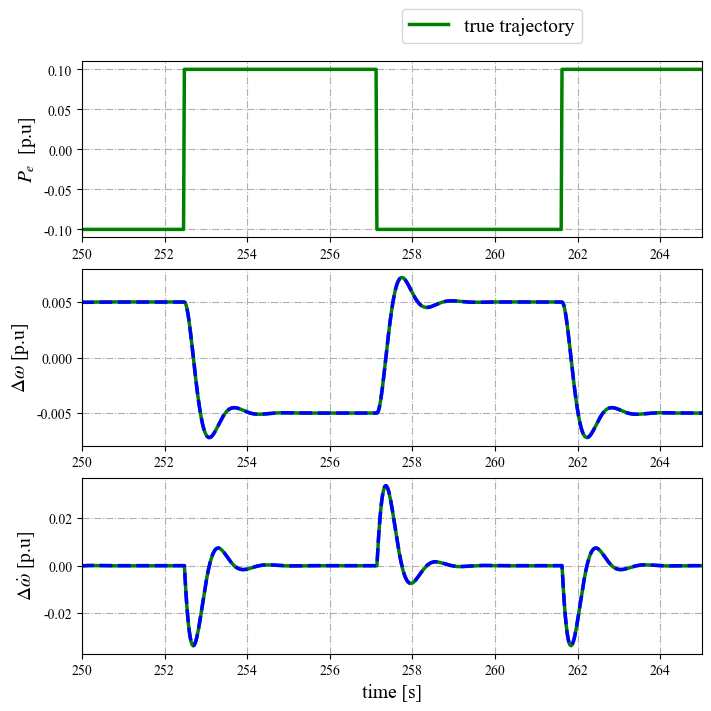

In [40]:
func2=ODEFunc2()
with torch.no_grad():
    pred_y0=odeint(func2, 0.02, y0, u0)
    # loss1=torch.mean(torch.abs(pred_y0-true_y0))
    criterion = nn.MSELoss()
    loss1 = criterion(pred_y0, true_y0)
    print('|Total Loss {:.12f}'.format(loss1.item()))
    visualize(t[0],u0[0,...], true_y0[0,...], pred_y0[0,...])

|Total Loss 0.000040016621


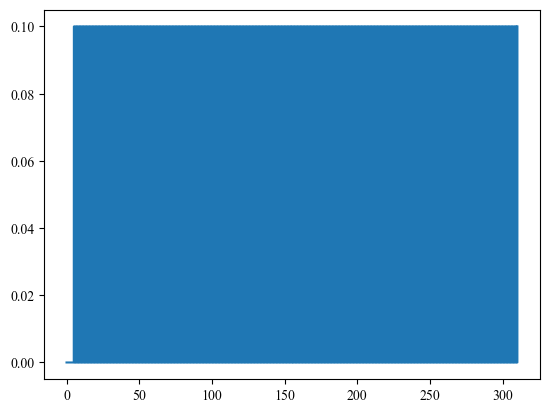

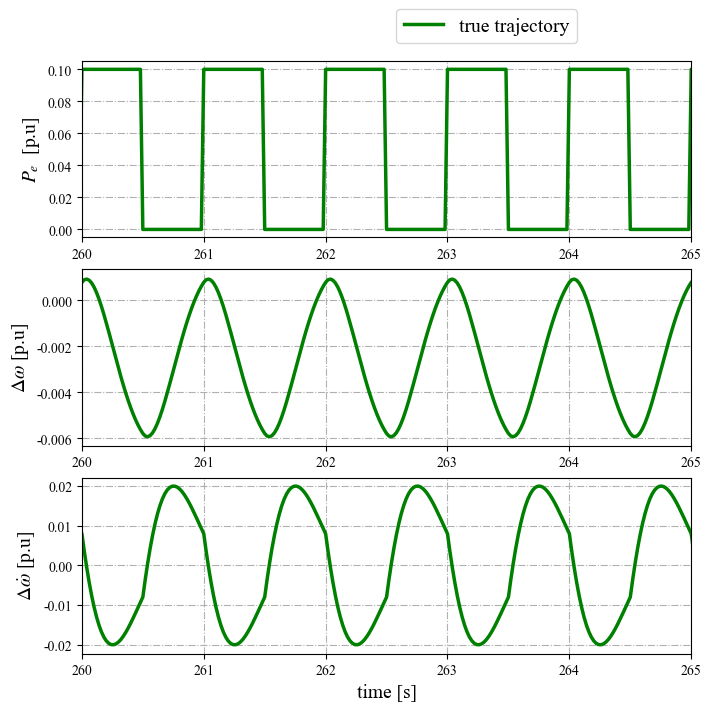

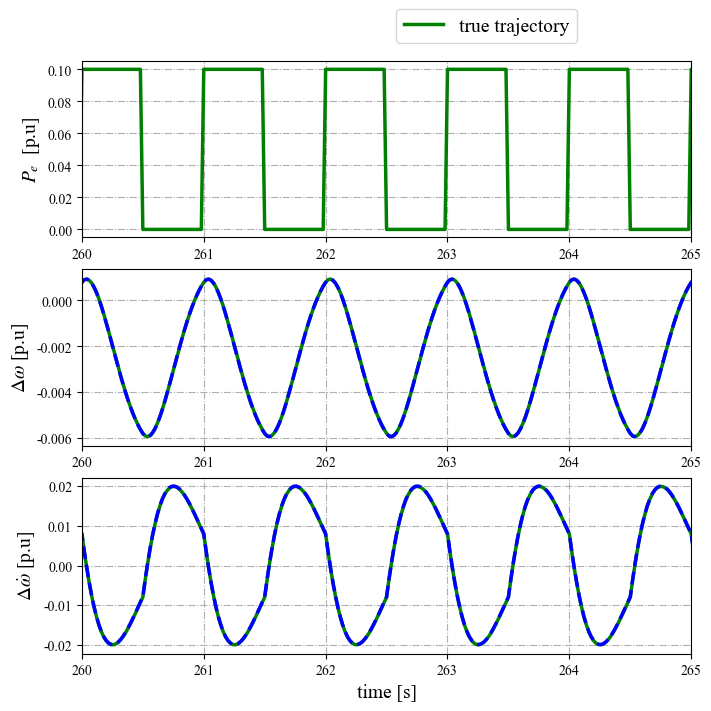

In [45]:
from Frequency_squarechirp_pyinterface import Frequency_squarechirp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import signal
import torch.nn.functional as F
# from Frequency_dynamic_system_pyinterface import Frequency_dynamic_system
model = Frequency_squarechirp(compile=False)
# inport=np.array([-0.105])
# inport1=np.array([0.095])
model.reset()

time_array = [model.current_time]
delta_omega = [model.deltaomega[0]]
delta_dotomega=[model.deltaomegadot[0]]
inputpower=[model.inputpower1[0]]

while model.current_time <= 310:
    model.one_step()
    time_array.append(model.current_time)
    delta_omega.append(model.deltaomega[0])
    delta_dotomega.append(model.deltaomegadot[0])
    inputpower.append(model.inputpower1[0])
plt.plot( time_array,inputpower)
b=torch.tensor([[delta_omega[250:],delta_dotomega[250:]]],dtype=torch.float32)
# b=torch.tensor([[delta_omega[250:2501]]],dtype=torch.float32).to(device)
true_y1=torch.movedim(b,(0,2),(1,0))
t=torch.tensor(time_array[250:],dtype=torch.float32)
u=torch.tensor(inputpower[250:],dtype=torch.float32)

true_y1 = true_y1.transpose(0, 1)
y0 = true_y1[:, 0, :]
t = t.reshape((1, -1))
u1 = u.reshape((1, -1, 1))

def visualize(t,u, true_y, pred_y):
    fig0, ax = plt.subplots(3, 1, figsize=(7, 7), constrained_layout=True)
    ax[0].plot(t.numpy(), u.numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
    # ax[0].set_title('Trained Model')
    # ax[0].set_xlabel('time [s]', fontsize = 14)
    ax[0].set_ylabel(r'$P_e$  [p.u]', fontsize = 14)
    ax[1].plot(t.numpy(), true_y.numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
    # ax[0].set_title('Trained Model',fontsize=14)
    # ax[1].set_xlabel('time [s]', fontsize = 14)
    ax[1].set_ylabel(r'$\Delta \omega$ [p.u]', fontsize = 14)
    ax[2].plot(t.numpy(), true_y.numpy()[:, 1],'green',label='true trajectory',  alpha=1,linewidth=2.5)
    # ax[1].set_title('Phase Portrait')
    ax[2].set_xlabel('time [s]', fontsize = 14)
    ax[2].set_ylabel(r'$\Delta\dot\omega$ [p.u]', fontsize = 14)
    if pred_y is not None:
        ax[1].plot(t,pred_y.numpy()[: ,0],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
        ax[2].plot(t,pred_y.numpy()[: ,1],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
   
    ax[0].set_xlim(260, 265)
    ax[1].set_xlim(260, 265)
    ax[2].set_xlim(260, 265)
    # ax[0].set_ylim(-0.00325,-0.0015)
    # ax[1].set_ylim(-0.03,0.018)
    
    ax[0].grid(True,linestyle = "-.")
    ax[1].grid(True,linestyle = "-.")
    ax[2].grid(True,linestyle = "-.")
    # plt.show()
    # ax[0].legend(fontsize=14, loc='upper left', ncol=2, bbox_to_anchor=(0.5,1.2))
    # ax[1].legend(fontsize=14, loc='upper left', ncol=2, bbox_to_anchor=(0.5,1.2))
    ax[0].legend(fontsize=14, loc='center left', ncol=2, bbox_to_anchor=(0.5,1.2))
    # plt.subplots_adjust(top=1)
    plt.savefig(f"trained.svg")
    
    
    
visualize(t[0], u1[0,...], true_y1[0,...], pred_y=None)

def rk4(odefun, Ts, x0, u0):
    k1 = odefun(x0, u0)
    k2 = odefun(x0+Ts/2*k1, u0)
    k3 = odefun(x0+Ts/2*k2, u0)
    k4 = odefun(x0 + Ts*k3, u0)
    xf = x0 + Ts/6*(k1 + 2*k2 + 2*k3 + k4)

    return xf

def odeint(func, Ts, x0, u):
    """
    Integrate ODE for given timesteps

    Parameters
    ----------
    func : ODE function

    t : torch.tensor
        Timesteps for which integration is to be done . Shape: `n_batch x n_steps`
    x0 : torch.tensor
        Initial states of shape `n_batch x n_states`
    u : torch.tensor
        Control inputs for each timestamps of shape `n_batch x n_steps x n_controls`

    Returns
    -------
    states for all timesteps
        `n_batch x n_steps x n_states`
    """

    n_batch = x0.shape[0]
    n_states = x0.shape[1]
    n_steps = t.shape[1]
    n_controls = u.shape[2]

    solution = torch.empty((n_batch, n_steps, n_states), dtype=x0.dtype)
    solution[:, 0, :] = x0


    y0 = x0
    for k in range(t.shape[1]-1):
        y1 = rk4(func, Ts, y0, u[:, k, :])
        solution[:,k+1,:] = y1
        y0 = y1

    return solution
class ODEFunc2(nn.Module):
    def __init__(self):
        super().__init__()
        ##make your ODE network
        self.net1=torch.load("net1_tara")
        self.net2=torch.load("net2_tara")
        self.net3=torch.load("net3_tara")
        
    def forward(self, y,u):
        output2=self.net2(u)
        output1=self.net1(y)
                #print(output1.shape,output2.shape, u.shape)
        output=torch.concat([output1, output2], axis=1)
        output = self.net3(output)
        
        return output
func2 = ODEFunc2()

func2 = ODEFunc2()
with torch.no_grad():
    pred_y1=odeint(func2, 0.02, y0, u1)
    loss2=torch.mean(torch.abs(pred_y1-true_y1))
    # criterion = nn.MSELoss()
    # loss2 = criterion(pred_y1, true_y1)
    print('|Total Loss {:.12f}'.format(loss2.item()))
    # print('|Total Loss {:.6f}'.format(loss1.item()))
    visualize(t[0],u1[0,...], true_y1[0,...], pred_y1[0,...])
# 2 / (45/0.02)

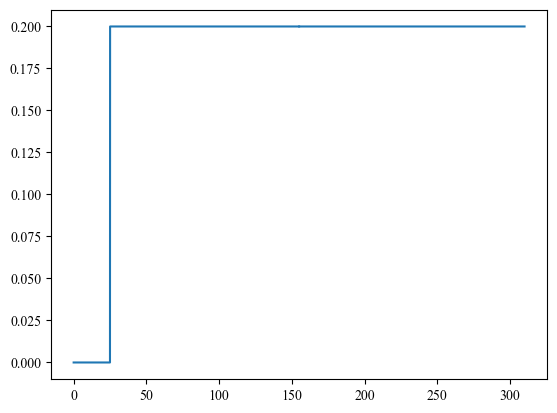

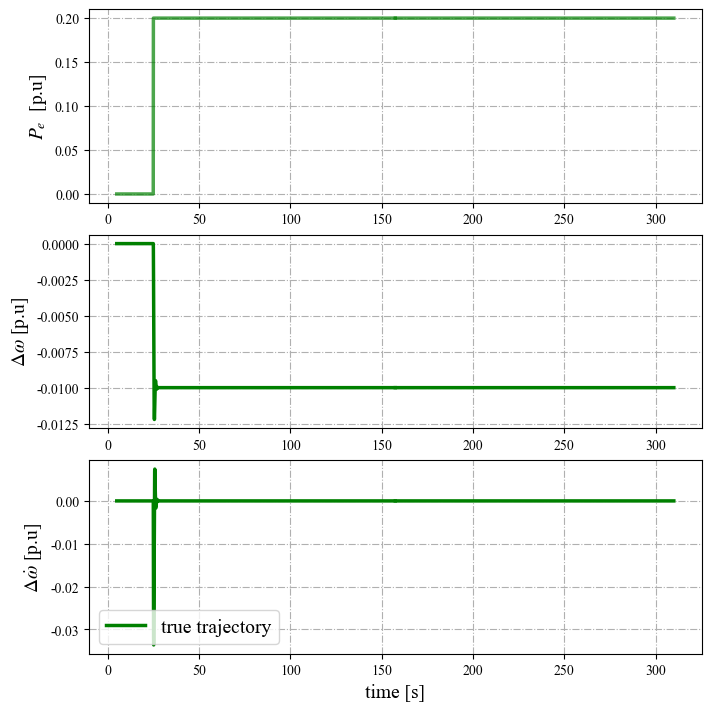

In [46]:
from Frequency_stepchirp_pyinterface import Frequency_stepchirp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import signal
import torch.nn.functional as F
# from Frequency_dynamic_system_pyinterface import Frequency_dynamic_system
model = Frequency_stepchirp(compile=False)
# fmin_e=np.array([0.1])
# fmax_m=np.array([1.0])
model.reset()

time_array = [model.current_time]
delta_omega = [model.deltaomega[0]]
delta_dotomega=[model.deltaomegadot[0]]
inputpower=[model.inputpower1[0]]

while model.current_time <= 310:
    model.one_step()
    time_array.append(model.current_time)
    delta_omega.append(model.deltaomega[0])
    delta_dotomega.append(model.deltaomegadot[0])
    inputpower.append(model.inputpower1[0])
plt.plot( time_array,inputpower)
b=torch.tensor([[delta_omega[250:],delta_dotomega[250:]]],dtype=torch.float32)
# b=torch.tensor([[delta_omega[250:2501]]],dtype=torch.float32).to(device)
true_y3=torch.movedim(b,(0,2),(1,0))
t3=torch.tensor(time_array[250:],dtype=torch.float32)
u3=torch.tensor(inputpower[250:],dtype=torch.float32)

true_y3 = true_y3.transpose(0, 1)
y0 = true_y3[:, 0, :]
t3 = t3.reshape((1, -1))
u3 = u3.reshape((1, -1, 1))

def visualize(t,u, true_y, pred_y):
    fig0, ax = plt.subplots(3, 1, figsize=(7, 7), constrained_layout=True)
    ax[0].plot(t.numpy(), u.numpy()[:, 0],'green',label='true trajectory', alpha=0.7,linewidth=2.5)
    # ax[0].set_title('Trained Model')
    # ax[0].set_xlabel('time [s]', fontsize = 14)
    ax[0].set_ylabel(r'$P_e$  [p.u]', fontsize = 14)
    ax[1].plot(t.numpy(), true_y.numpy()[:, 0],'green',label='true trajectory', alpha=1,linewidth=2.5)
    # ax[0].set_title('Trained Model')
    # ax[1].set_xlabel('time [s]', fontsize = 14)
    ax[1].set_ylabel(r'$\Delta \omega$ [p.u]', fontsize = 14)
    ax[2].plot(t.numpy(), true_y.numpy()[:, 1],'green',label='true trajectory', alpha=1,linewidth=2.5)
    # ax[1].set_title('Phase Portrait')
    ax[2].set_xlabel('time [s]', fontsize = 14)
    ax[2].set_ylabel(r'$\Delta\dot\omega$ [p.u]', fontsize = 14)
    if pred_y is not None:
        ax[1].plot(t,pred_y.numpy()[: ,0],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
        ax[2].plot(t,pred_y.numpy()[: ,1],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
    
    # ax[0].set_xlim(19, 22)
    # ax[1].set_xlim(19, 23)
    # ax[2].set_xlim(19, 23)
    # ax[0].set_ylim(-0.00325,-0.0015)
    # ax[1].set_ylim(-0.03,0.018)
    plt.legend(fontsize=14,loc=3, ncol=2)
    ax[0].grid(True,linestyle = "-.")
    ax[1].grid(True,linestyle = "-.")
    ax[2].grid(True,linestyle = "-.")
    # plt.show()
    plt.savefig(f"trained_step.svg")
    
    
    
visualize(t3[0], u3[0,...], true_y3[0,...], pred_y=None)

In [47]:
def rk4(odefun, Ts, x0, u0):
    k1 = odefun(x0, u0)
    k2 = odefun(x0+Ts/2*k1, u0)
    k3 = odefun(x0+Ts/2*k2, u0)
    k4 = odefun(x0 + Ts*k3, u0)
    xf = x0 + Ts/6*(k1 + 2*k2 + 2*k3 + k4)

    return xf

def odeint(func, Ts, x0, u):
    """
    Integrate ODE for given timesteps

    Parameters
    ----------
    func : ODE function

    t : torch.tensor
        Timesteps for which integration is to be done . Shape: `n_batch x n_steps`
    x0 : torch.tensor
        Initial states of shape `n_batch x n_states`
    u : torch.tensor
        Control inputs for each timestamps of shape `n_batch x n_steps x n_controls`

    Returns
    -------
    states for all timesteps
        `n_batch x n_steps x n_states`
    """

    n_batch = x0.shape[0]
    n_states = x0.shape[1]
    n_steps = t.shape[1]
    n_controls = u.shape[2]

    solution = torch.empty((n_batch, n_steps, n_states), dtype=x0.dtype)
    solution[:, 0, :] = x0


    y0 = x0
    for k in range(t.shape[1]-1):
        y1 = rk4(func, Ts, y0, u[:, k, :])
        solution[:,k+1,:] = y1
        y0 = y1

    return solution
class ODEFunc2(nn.Module):
    def __init__(self):
        super().__init__()
        ##make your ODE network
        self.net1=torch.load("net1_tara")
        self.net2=torch.load("net2_tara")
        self.net3=torch.load("net3_tara")
        
    def forward(self, y,u):
        output2=self.net2(u)
        output1=self.net1(y)
                #print(output1.shape,output2.shape, u.shape)
        output=torch.concat([output1, output2], axis=1)
        output = self.net3(output)
        
        return output
func2 = ODEFunc2()

|Total Loss 0.000025


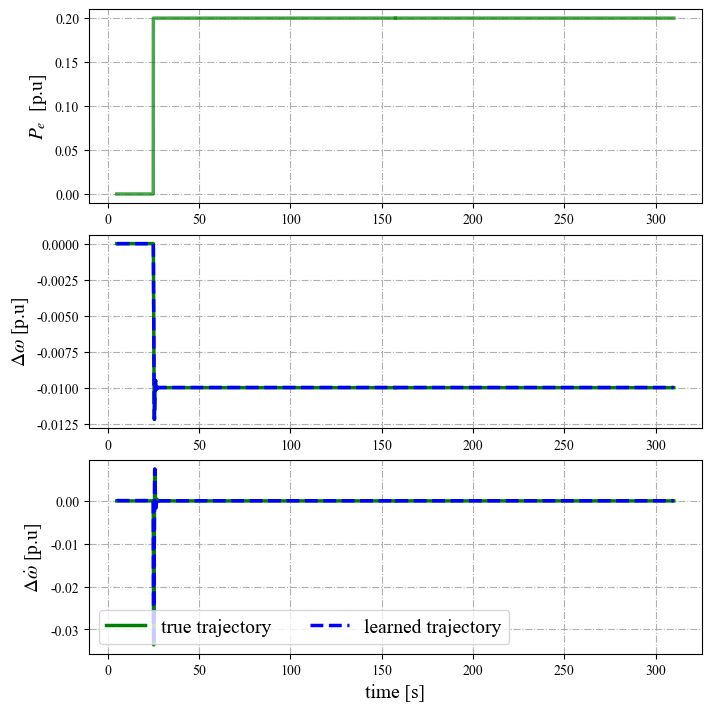

In [48]:
with torch.no_grad():
    pred_y3=odeint(func2, 0.02, y0, u3)
    loss1=torch.mean(torch.abs(pred_y3-true_y3))
    print('|Total Loss {:.6f}'.format(loss1.item()))
    visualize(t3[0], u3[0,...],true_y3[0,...], pred_y3[0,...])

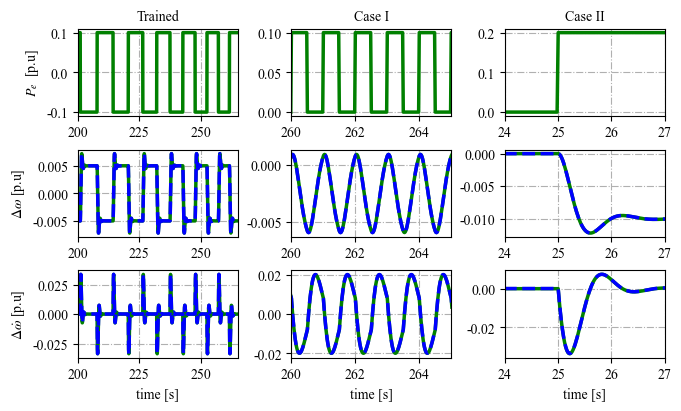

In [50]:
fig0, ax = plt.subplots(3, 3, figsize=(6.7, 4), constrained_layout=True)
ax[0][0].plot(t[0].numpy(), u0[0,...].numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
ax[0][0].set_title('Trained',fontsize=10)
ax[0][0].set_ylabel(r'$P_e$  [p.u]', fontsize = 10)
ax[1][0].plot(t[0].numpy(), true_y0[0,...].numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
ax[2][0].plot(t[0].numpy(), true_y0[0,...].numpy()[:, 1],'green',label='true trajectory',  alpha=1,linewidth=2.5)
ax[1][0].set_ylabel(r'$\Delta \omega$ [p.u]', fontsize = 10)
ax[2][0].set_xlabel('time [s]', fontsize = 10)
ax[2][0].set_ylabel(r'$\Delta\dot\omega$ [p.u]', fontsize = 10)
ax[1][0].plot(t[0],pred_y0[0,...].numpy()[: ,0],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
ax[2][0].plot(t[0],pred_y0[0,...].numpy()[: ,1],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
ax[0][0].set_xlim(200, 265)
ax[1][0].set_xlim(200, 265)
ax[2][0].set_xlim(200, 265)
ax[0][0].grid(True,linestyle = "-.")
ax[1][0].grid(True,linestyle = "-.")
ax[2][0].grid(True,linestyle = "-.")


#Second column
ax[0][1].plot(t[0].numpy(), u1[0,...].numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
ax[0][1].set_title('Case I',fontsize=10)
# ax[0][1].set_ylabel(r'$P_e$  [p.u]', fontsize = 12)
ax[1][1].plot(t[0].numpy(), true_y1[0,...].numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
# ax[1][1].set_ylabel(r'$\Delta \omega$ [p.u]', fontsize = 12)
ax[2][1].plot(t[0].numpy(), true_y1[0,...].numpy()[:, 1],'green',label='true trajectory',  alpha=1,linewidth=2.5)
ax[2][1].set_xlabel('time [s]', fontsize = 10)
# ax[2][1].set_ylabel(r'$\Delta\dot\omega$ [p.u]', fontsize = 12)
ax[1][1].plot(t[0],pred_y1[0,...].numpy()[: ,0],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
ax[2][1].plot(t[0],pred_y1[0,...].numpy()[: ,1],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
ax[0][1].set_xlim(260, 265)
ax[1][1].set_xlim(260, 265)
ax[2][1].set_xlim(260, 265)
ax[0][1].grid(True,linestyle = "-.")
ax[1][1].grid(True,linestyle = "-.")
ax[2][1].grid(True,linestyle = "-.")

#Third column
ax[0][2].plot(t[0].numpy(), u3[0,...].numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
ax[0][2].set_title('Case II', fontsize=10)
# ax[0][2].set_ylabel(r'$P_e$  [p.u]', fontsize = 12)
ax[1][2].plot(t[0].numpy(), true_y3[0,...].numpy()[:, 0],'green',label='true trajectory',  alpha=1,linewidth=2.5)
# ax[1][2].set_ylabel(r'$\Delta \omega$ [p.u]', fontsize = 12)
ax[2][2].plot(t[0].numpy(), true_y3[0,...].numpy()[:, 1],'green',label='true trajectory',  alpha=1,linewidth=2.5)
ax[2][2].set_xlabel('time [s]', fontsize = 10)
# ax[2][2].set_ylabel(r'$\Delta\dot\omega$ [p.u]', fontsize = 10)
ax[1][2].plot(t[0],pred_y3[0,...].numpy()[: ,0],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
ax[2][2].plot(t[0],pred_y3[0,...].numpy()[: ,1],'blue',label='learned trajectory', alpha=1,linewidth=2.5, linestyle='dashed')
ax[0][2].set_xlim(24, 27)
ax[1][2].set_xlim(24, 27)
ax[2][2].set_xlim(24, 27)
ax[0][2].grid(True,linestyle = "-.")
ax[1][2].grid(True,linestyle = "-.")
ax[2][2].grid(True,linestyle = "-.")
# ax[2][2].legend(fontsize=10, loc='center', ncol=2, borderpad=0.2, labelspacing=0.2)
# plt.legend(loc='upper center', ncol=1)

plt.savefig(f"results2.svg")